In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Kuramoto_model import Kuramoto_2nd_mf

from TO_sim.get_cluster import cluster_os_new2
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian
import TO_sim.Integrator_jit as IJ
from scipy.integrate import quad

RK4_jit = IJ.RK4

In [18]:
K = 4
m = 6

In [19]:
Opf = lambda r,K=K,m=m:  (4/np.pi)*np.sqrt(K*r/m)
Odf = lambda r,K=K,m=m:  K*r
def Main_r(r,K=K,m=m):
    Op = Opf(r,K,m)
    r_ = norm.cdf(Op) - norm.cdf(-Op)
    return r_-r

def sec_r(r2,Opm,K=K,m=m):
    Opp = Opf(r2,K,m) + Opm
    r_ = norm.cdf(Opp) - norm.cdf(Opm)
    return r_-r2


In [98]:
def Bisection(f,r_a,r_b,eps =1e-5,arg=()):
    r_c = (r_a+r_b)/2
    num = 0 
    
    while abs(f(r_c,*arg))>eps:
        r_c = (r_a+r_b)/2
        if f(r_a,*arg)*f(r_c,*arg)>0:
            r_a = r_c
        else:
            r_b = r_c
        num+=1
        if num >50:
            print('Please select another section')
            return np.NAN
    print(f'count : {num}')
    return r_c

In [21]:
K=9
m=6

In [ ]:
r_lock2(r,O_r,O_pm,K=K,m=m,g=g_sec)

In [22]:
r_0 = 0.5
eps = 1e-5
f = lambda r,K=K,m=m:Main_r(r,K=K,m=m)
r_m = Bisection(f,0.1,1)
Opm = norm.ppf(r_m/2+0.5)
Od = Odf(r_m,K,m)
print('Od',Od)
print('r_m',r_m)
print('Opm',Opm)
if Opm < Od:
    print('Pass O_p < O_d; main cluster exist')
else:
    print('Opps! O_p > O_d; main cluster blow up')
Od = Odf(r_m,K,m)

r_s = Bisection(sec_r,0.01,(1-r_m),arg=(Opm,K,m))
Op2 = norm.ppf(r_m/2+r_s+0.5)
Op2_ = Opf(r_s*2,K=K,m=m)
Od2_ = Odf(r_s*2,K=K,m=m)

print('r_s',r_s)
print('Op2',Op2)
if (Op2 < Od)and(Op2_<Od2_):
    print('Pass O_p3 < O_d; secondary cluster exist')
else:
    print('Opps! O_pp > O_d; secondary cluster blow up')
    
r_3 = Bisection(sec_r,0.01,0.5,arg=(Op2,K,m))/2
Op3 = norm.ppf(r_m/2+r_s+r_3+0.5)
Op3_ = Opf(r_3*2,K=K,m=m)
Od3_ = Odf(r_3*2,K=K,m=m)

print('r_3',r_3)
print('Op3',Op3)

if (Op3 < Od)and(Op3_<Od3_):
    print('Pass O_p3 < O_d; third cluster exist')
else:
    print('Opps! O_p3 > O_d; third cluster blow up')

Od 7.643902587890626
r_m 0.8493225097656251
Opm 1.437142559868397
Pass O_p < O_d; main cluster exist
r_s 0.03242734402418135
Op2 1.7178564490937243
Pass O_p3 < O_d; secondary cluster exist
r_3 0.0073028564453125
Op3 1.8040907007638494
Opps! O_p3 > O_d; third cluster blow up


In [23]:
Od = Odf(r_m,K,m)

r_s = Bisection(sec_r,0.01,0.5,arg=(Opm,K,m))
Opp = Opf(r_m,K=K,m=m) + Opm
print('r_s',r_s)
print('Opp',Opp)
if Opp < Od:
    print('Pass O_p3 < O_d; secondary cluster exist')
else:
    print('Opps! O_pp > O_d; secondary cluster blow up')

r_s 0.03243041992187501
Opp 2.874259356654524
Pass O_p3 < O_d; secondary cluster exist


In [24]:
def g_n(x):
    return norm.pdf(x,0,1)

In [25]:
def r_0(r,K=K,m=m,g=g_n):
    X = K*r
    O_d = X
    theta_0 = np.arcsin(O_d/X)
    integrand_l = lambda x:np.cos(x)**2*g(X*np.sin(x))
    integrand_d = lambda x:(1/x**3)*g(x)
    I_l,err_l = quad(integrand_l,-theta_0,theta_0,limit=200) #lock
    I_d,err_d = quad(integrand_d,O_d,np.inf,limit=200) #drift
    r0 = X*I_l - X/(m**2)*I_d
    return r0 - r

In [1]:
m

NameError: name 'm' is not defined

In [27]:
Opf = lambda r,K=K,m=m:  (4/np.pi)*np.sqrt(K*r/m)
Odf = lambda r,K=K,m=m:  K*r

In [182]:
def r_lock1(r,K=K,m=m,g=g_n):
    X = K*r
    integrand_lock = lambda x:np.cos(x)**2*g(X*np.sin(x))
    omega_p = (4/np.pi)*np.sqrt(X/m)

    A = omega_p/X
    if abs(A)<=1:
        theta_p = np.arcsin(A)
        I_l,err = quad(integrand_lock,-theta_p,theta_p,limit=200)
        return X*I_l

    else: 
        theta_p = np.arcsin(A)
        I_l,err = quad(integrand_lock,-np.pi/2,np.pi/2,limit=200)
        return X*I_l
    

def r_drift1(r,K=K,m=m,g=g_n):
    X = K*r
    O_p = (4/np.pi)*np.sqrt(X/m)
    integrand_drift = lambda x:1/(x**2)*g(x)
    I_d,err = quad(integrand_drift,O_p,np.inf,limit=200)
    return -X/(m)*I_d

def r_main(r,K=K,m=m,g=g_n):
    rl = r_lock1(r,K=K,m=m,g=g_n)
    rd = 0#r_drift1(r,K=K,m=m,g=g_n)
    return rl+rd - r



def r_mean(r,K=K,m=m,g=g_n):
    rl = r_lock1(r,K=K,m=m,g=g_n)
    rd = r_drift1(r,K=K,m=m,g=g_n)
    return rl+rd - r

In [170]:
def A(r,K=K,m=m):
    return 1/np.sqrt(K*r*m)

def B(r,CS,CM,K=K,m=m):
    return (CS-CM)/(K*r)
def M_theta(r,CS,CM,K=K,m=m):
    a = A(r,K=K,m=m)
    b = B(r,CS,CM,K=K,m=m)
    return - a**2/(2*b**2)
# cm = np.mean(np.cos(psi_clu[1]-psi_clu[0])[-5000:])
# M = M_theta(rs_clu_mean[0][-1],CMO[1],CMO[0])
# print(cm,M)

In [171]:
np.arcsin(abs(0.01))

0.010000166674167114

In [166]:
np.arcsin(100)

C:\Users\kim9y\AppData\Local\Temp\ipykernel_22880\148648433.py:1: RuntimeWarning: invalid value encountered in arcsin
  np.arcsin(100)


nan

In [179]:
def r_ls(rs,rm,O_pm,O_r,K=K,m=m,g=g_n):
    X = K*rm
    Xs = K*rs
    # O_pm = (4/np.pi)*np.sqrt(X/m)
    
    integrand_lock = lambda x:np.cos(x)**2*(g(Xs*np.sin(x)+O_r))
    O_ps = (4/np.pi)*np.sqrt(Xs/m)
    if O_pm<O_r-O_ps:
        left = (O_pm-O_r)/Xs
    else:
        left = -O_ps/Xs
    A = O_ps/Xs
    if (abs(A)<=1)&(abs(left)<=1):
        theta_pr = np.arcsin(A)
        theta_pl = np.arcsin(abs(left))
        I_l,err = quad(integrand_lock,-theta_pl,theta_pr,limit=200)
        return Xs*I_l

    else: return 0 

def r_ds(rs,rm,O_pm,O_r,K=K,m=m,g=g_n):
    X = K*rm
    Xs = K*rs
    # O_pm = (4/np.pi)*np.sqrt(X/m)
    O_ps = (4/np.pi)*np.sqrt(Xs/m)
    integrand_drift = lambda x,m=m:1/((2*(x)**2))*g(x+O_r)
    if O_pm<O_r-O_ps:
        O_pl = (O_pm-O_r)
        I_dl = 0
    else:
        O_pl = -O_ps
        I_dl,err = quad(integrand_drift,-np.inf,O_pl,limit=200)
        
    I_dr,err = quad(integrand_drift,O_ps,np.inf,limit=200)
    
    return -Xs/(m)*(I_dr+I_dl)



def r_2nd(rs,rm,O_pm,K=K,m=m,g=g_n):
    temp = np.linspace(0.5+rm/2,1,10000,endpoint=False)
    O_r = np.mean(norm.ppf(temp))
    rl = r_ls(rs,rm,O_pm,O_r,K=K,m=m,g=g_n)
    rd = r_ds(rs,rm,O_pm,O_r,K=K,m=m,g=g_n)
    rs = rl+rd
    # if rs==0:
    #     A = 0
    # else:
    #     A = (4/np.pi)*np.sqrt(K*rs/m)
    # O_p2 = O_pm + (4/np.pi)*np.sqrt(K*rs/m)

    l2 = np.linspace(rm/2+0.5,rm/2+rs+0.5,1000)

    O_p2 = np.mean(norm.ppf(l2))
    # O_p2 = O_pm + (4/np.pi)*np.sqrt(K*rs/m)/2
    # O_p2 = Opf(rm+2*rs)
    r_mm = M_theta(rm,O_p2,0)*rm/2
    
    return rl+r_mm-rs#+rd+r_mm-rs

def r_3rd(r3,rm,O_pm,r2,O_p2,K=K,m=m,g=g_n):
    rl = r_ls(r2,rm,O_pm,K=K,m=m,g=g_n)
    rd = r_ds(r2,rm,O_pm,K=K,m=m,g=g_n)
    r3 = rl+rd
    O_p3 = O_p2 + (4/np.pi)*np.sqrt(K*r3/m)
    r_mm = M_theta(rm,O_p2,0)*rm/2
    r_2m = M_theta(r2,O_p3,O_pm)*r2
    r_2p = M_theta(r2,O_p3,-O_pm)*r2
    
    return rl+rd+r_2m -r3/2

In [118]:
temp = np.linspace(0.5+r_m/2,1,10000,endpoint=False)
O_r = np.mean(norm.ppf(temp))

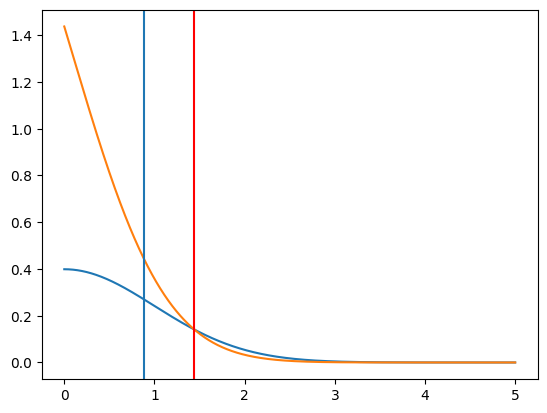

In [122]:
xss = np.linspace(0,5,10000)
plt.plot(xss,norm.pdf(xss))
plt.plot(xss,norm.pdf(xss+O_pm)/(0.5-r_m/2))
plt.axvline(O_pm)
plt.axvline(O_r,color='red')

In [126]:
np.mean(norm.pdf(xss+O_pm)/(0.5-r_m/2))*5

1.000259390962916

In [55]:
norm.pdf(1)

0.24197072451914337

In [77]:
2<3

True

In [73]:
norm.ppf(0.5+r_m/2)

0.8896664395759608

In [75]:
temp = np.linspace(0.5,1,10000,endpoint=False)
np.mean(norm.ppf(temp))

0.7976689188861785

In [81]:
norm.pdf(15)

5.530709549844416e-50

In [100]:
(0.5-r_m/2)

0.09341125488281249

In [74]:
temp = np.linspace(0.5+r_m/2,1,10000,endpoint=False)
np.mean(norm.ppf(temp))

1.4373168205639093

In [78]:
def nmean(omega):
    return omega*norm.pdf(omega)
quad(nmean,1,np.inf,limit=200)

(0.24197072451914342, 3.4353786464771963e-10)

In [32]:
M_theta(r_m,O_pm/2,-O_pm)

NameError: name 'O_pm' is not defined

In [33]:
M_theta(r_2,1.6214522,O_p2)*r_2/2

NameError: name 'r_2' is not defined

In [666]:
M_theta(r_m,O_pp,0)

-0.1235186102253833

In [39]:
K = 5
m = 6

In [40]:
norm.pdf(0.76434326171875/2)

0.3708468477431685

In [183]:
r_m = Bisection(r_mean,0.1,1,arg = (K,m,g_n))
print(r_m)
# O_pm = norm.ppf(r_m/2+0.5)
# O_pm
# O_pm
print('K,m',K,m)

count : 14
0.5402770996093751
K,m 5 6


In [174]:
r_m = Bisection(r_main,0.1,1,arg = (K,m,g_n))
print(r_m)
O_pm = norm.ppf(r_m/2+0.5)
O_pm
O_pm
print('K,m',K,m)

count : 14
0.6389343261718752
K,m 5 6


In [147]:
norm.ppf(r_m/2+0.5)

0.8896664395759608

In [176]:
Od = Odf(r_m,K,m)

r_s = Bisection(sec_r,0.01,(1-r_m),arg=(Opm,K,m))
Op2 = norm.ppf(r_m/2+r_s+0.5)
Op2_ = Opf(r_s,K=K,m=m)
Od2_ = Odf(r_s*2,K=K,m=m)

print('r_s',r_s)
print('Op2',Op2)
if (Op2 < Od)and(Op2_<Od2_):
    print('Pass O_p3 < O_d; secondary cluster exist')
else:
    print('Opps! O_pp > O_d; secondary cluster blow up')
    
r_3 = Bisection(sec_r,0.01,0.5,arg=(Op2,K,m))/2
Op3 = norm.ppf(r_m/2+r_s+r_3+0.5)
Op3_ = Opf(r_3*2,K=K,m=m)
Od3_ = Odf(r_3*2,K=K,m=m)

print('r_3',r_3)
print('Op3',Op3)

if (Op3 < Od)and(Op3_<Od3_):
    print('Pass O_p3 < O_d; third cluster exist')
else:
    print('Opps! O_p3 > O_d; third cluster blow up')

count : 13
r_s 0.02127078518271446
Op2 0.9974954042035493
Pass O_p3 < O_d; secondary cluster exist
count : 12
r_3 0.029464111328125
Op3 1.1273468041795076
Pass O_p3 < O_d; third cluster exist


In [149]:
l = np.linspace(0,0.0655/2,1000)
np.mean(norm.ppf(r_m/2+l+0.5))
# norm.ppf(r_m/2+r_2+0.5)

0.953063796879808

In [150]:
(0.01+(1-r_m))/2

0.19182250976562498

In [165]:
r_2nd(0.30,r_m,O_pm,K,m,g_n)

nan

In [180]:
r_2 = Bisection(r_2nd,0.01,(1-r_m)/2,arg = (r_m,O_pm,K,m,g_n))
print(r_2)
O_p2 = norm.ppf(r_m/2+r_2+0.5)
O_p2 = O_pm + Opf(2*r_2,K=K,m=m)
print('O_p2',O_p2)
O_p2_f = Opf(r_2*2)
O_p2_d = Odf(r_2*2)
O_p2_f<O_p2_d

Please select another section
nan
O_p2 nan


False

In [214]:
l = np.linspace(0,r_2/2,1000)
np.mean(norm.ppf(r_m/2+l+0.5))

1.2691485287178896

In [ ]:
def check_secondary(K,m):
    r_m = Bisection(r_main,0.1,1,arg = (K,m,g_n))
    O_pm = Opf(r_m)
    r_2 = Bisection(r_2nd,0.06,(1-r_m)/2,arg = (r_m,O_pm,K,m,g_n))
    O_p2 = Opf(r_m+r_s*2)#+Opf(r_s/2)

In [506]:
r_3rd(0.5,r_m,O_pm,r_2,O_p2,K,m,g_n)

0.013152093393947163

In [507]:
r_3 = Bisection(r_3rd,0.01,(1-r_m-r_2)/2,arg = (r_m,O_pm,r_2,O_p2,K,m,g_n))
print(r_3)
O_p3 = Opf(r_m)+Opf(2*r_s)+Opf(2*r_3)
O_p3

Please select another section
nan


nan

In [455]:
M_theta(r_2,1.6,O_p2)*r_2/2

-0.15537764974342247

In [433]:
r_3 = Bisection(r_3rd,0.06,(1-r_m)/2,arg = (r_m,O_pp,K,m,g_n))
print(r_3)
O_p3 = Opf(r_m+r_s*2+r_3*2)
O_p3

count : 12
0.13557907305657863


1.244987166897404

In [420]:
O_pp = Opf(r_m+r_s*2)
O_pp

1.0879669977347337

In [398]:
O_pp = Opf(r_m+r_s)
O_pp

0.9968569845990712

In [90]:
Od = Odf(r_m,K,m)
r_s = Bisection(sec_r,0.01,(1-r_m),arg=(O_pm,K,m))
Opp = Opf(r_m/2,K=K,m=m) + O_pm
print('r_s',r_s)
print('Opp',Opp)
if Opp < Od:
    print('Pass O_p3 < O_d; secondary cluster exist')
else:
    print('Opps! O_pp > O_d; secondary cluster blow up')
    

r_s 0.05123634487390519
Opp 2.4053093495915343
Pass O_p3 < O_d; secondary cluster exist


In [337]:
r_s*500

102.79897570610045

In [9]:
def A(r,K=K,m=m):
    return 1/np.sqrt(K*r*m)

def B(r,CS,CM,K=K,m=m):
    return (CS-CM)/(K*r)
def M_theta(r,CS,CM,K=K,m=m):
    a = A(r,K=K,m=m)
    b = B(r,CS,CM,K=K,m=m)
    return - a**2/(2*b**2)

In [52]:
m = 5
K = 6

In [53]:
r_m = Bisection(r_main,0.1,1,arg = (K,m,g_n))
print(r_m)
O_pm = norm.ppf(r_m/2+0.5,loc=0,scale=1)
O_pm

count : 13
0.76434326171875


1.185912798612868

In [34]:
norm.ppf(r_m/2+0.5,loc=0,scale=1)

1.185912798612868

In [35]:
r_s = Bisection(r_sec,0.06,(1-r_m)/2,arg = (r_m,O_pm,K,m,g_n))
print(r_s)
O_pp = Opf(r_m+r_s)
O_pp

NameError: name 'r_sec' is not defined

In [365]:
r_3 = Bisection(r_sec,0.01,(1-r_m-r_s*2)/2,arg = (r_m,O_pp,K,m,g_n))
r_3

Please select another section


nan

In [355]:
O_p3 = Opf(r_m)+Opf(r_s)
O_p3

nan

In [356]:
r_3 = Bisection(r_sec,0.01,0.5,arg = (r_m,O_p3,K,m,g_n))
r_3

count : 0


C:\Users\kim9y\AppData\Local\Temp\ipykernel_31104\864942427.py:12: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I_l,err = quad(integrand_lock,0,theta_p,limit=200)
C:\Users\kim9y\AppData\Local\Temp\ipykernel_31104\864942427.py:24: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I_dp,err = quad(integrand_drift,O_pp,np.inf,limit=200)


0.255

In [ ]:
r_3 = Bisection(r_sec,0.01,0.5,arg = (r_3,K,m,g_n))
r_3

In [113]:
CS/N

array([0.60925, 0.1295 , 0.12925])

In [125]:
r_ls(0.1,r_m,K=K,m=m,g=g_n)
# r_ds(0.3,r_m,K=K,m=m,g=g_n)

0.11867126063543693

In [10]:
Opf = lambda r,K=K,m=m:  (4/np.pi)*np.sqrt(K*r/m)
Odf = lambda r,K=K,m=m:  K*r
def Main_r(r,K=K,m=m):
    Op = Opf(r,K,m)
    r_ = norm.cdf(Op) - norm.cdf(-Op)
    return r_-r

def sec_r(r2,Opm,K=K,m=m):
    Opp = Opf(r2,K,m) + Opm
    r_ = norm.cdf(Opp) - norm.cdf(Opm)
    return r_-r2/2

In [11]:
def Bisection(f,r_a,r_b,eps =1e-5,arg=()):
    r_c = (r_a+r_b)/2
    num = 0 
    
    while abs(f(r_c,*arg))>eps:
        r_c = (r_a+r_b)/2
        if f(r_a,*arg)*f(r_c,*arg)>0:
            r_a = r_c
        else:
            r_b = r_c
        num+=1
        if num >1000:
            print('Please select another section')
            break
    print(f'count : {num}')
    return r_c

def Bisection_withf(f,r_a,r_b,eps =1e-5,arg=()):
    fc = lambda r: f(r,*arg) - r
    r_c = (r_a+r_b)/2
    num = 0 
    
    while abs(fc(r_c))>eps:
        r_c = (r_a+r_b)/2
        if fc(r_a)*fc(r_c)>0:
            r_a = r_c
        else:
            r_b = r_c
        num+=1
        if num >1000:
            print('Please select another section')
            break
    print(f'count : {num}')
    return r_c



In [152]:
K = 2
m = 6

In [153]:
r_m = Bisection(r_main,0.1,1,arg = (K,m,g_n))
r_m

C:\Users\kim9y\AppData\Local\Temp\ipykernel_31104\1260678388.py:13: RuntimeWarning: invalid value encountered in arcsin
  theta_p = np.arcsin(A)


count : 13


0.22886962890625

In [154]:
r_m = Bisection_withf(r_lock1,0.1,1,arg = (K,m,g_n))
r_m

count : 8


C:\Users\kim9y\AppData\Local\Temp\ipykernel_31104\1260678388.py:13: RuntimeWarning: invalid value encountered in arcsin
  theta_p = np.arcsin(A)


0.27226562500000007

In [78]:
f = lambda r,K=K,m=m:Main_r(r,K=K,m=m)
r_m = Bisection(f,0.1,1)
r_m

count : 15


0.6520355224609375

In [372]:
# r_0 = 0.5
eps = 1e-5
f = lambda r,K=K,m=m:Main_r(r,K=K,m=m)
r_m = Bisection(f,0.1,1)
Opm = Opf(r_m,K,m)
Od = Odf(r_m,K,m)
print('Od',Od)
print('r_m',r_m)
print('Opm',Opm)
if Opm < Od:
    print('Pass O_p < O_d; main cluster exist')
else:
    print('Opps! O_p > O_d; main cluster blow up')

r_s = Bisection(sec_r,0.01,0.5,arg=(Opm,K,m))/2
Opp = Opf(r_s,K=K,m=m) + Opm
print('r_s',r_s)
print('Opp',Opp)
if Opp < Od:
    print('Pass O_p3 < O_d; secondary cluster exist')
else:
    print('Opps! O_pp > O_d; secondary cluster blow up')
    
r_3 = Bisection(sec_r,0.01,0.5,arg=(Opp,K,m))/2
Op3 = Opf(r_3,K=K,m=m) + Opp

print('r_3',r_3)
print('Op3',Op3)

if Op3 < Od:
    print('Pass O_p3 < O_d; third cluster exist')
else:
    print('Opps! O_p3 > O_d; third cluster blow up')

count : 13
Od 3.6684814453125005
r_m 0.6114135742187501
Opm 0.8622005360808083
Pass O_p < O_d; main cluster exist
count : 11
r_s 0.11063232421875
Opp 1.228960370941933
Pass O_p3 < O_d; secondary cluster exist
count : 12
r_3 0.053629150390625005
Op3 1.4843135145367061
Pass O_p3 < O_d; third cluster exist


In [ ]:
〈cos θ 〉=−a2 2b2 ,

In [90]:
def A(r,K=K,m=m):
    return 1/np.sqrt(K*r*m)

def B(r,CS,CM,K=K,m=m):
    return (CS-CM)/(K*r)
def M_theta(r,CS,CM,K=K,m=m):
    a = A(r,K=K,m=m)
    b = B(r,CS,CM,K=K,m=m)
    return - a**2/(2*b**2)

In [ ]:
mean_theta = cos